# Room Environment v3 - Convergence Analysis

This notebook analyzes the periodic behavior and convergence properties of Room
Environment v3 across multiple configurations, focusing on the transition from initial
transient behavior to stable periodic dynamics.

## Theoretical Framework

### Two-Phase Dynamics

Room Environment v3 exhibits **two-phase dynamics**:

1. **Transient Phase (0 ≤ t < $T_{settling}$)**: Objects move from random initial positions
   toward their periodic trajectories
2. **Periodic Phase (t ≥ $T_{settling}$)**: Objects follow deterministic periodic patterns

### State Space Definition

We define a **world state** that excludes agent location and questions:

**State = (Inner Wall Configuration, Object Locations)**

Where:

- Inner walls follow predetermined periodic patterns with **variable periods**
- Moving objects have deterministic movement preferences
- Static objects remain fixed

### Settling Time Analysis

The **settling time** $T_{settling}$ is the number of steps required for objects to
synchronize with the periodic environment. This depends on:

1. **Initial Position Randomness**: Objects start in random rooms
2. **Wall Pattern Alignment**: Walls follow periodic patterns with different periods
3. **Movement Constraints**: Objects must navigate around walls and avoid collisions
4. **Convergence to Attractors**: Objects eventually reach periodic trajectories

### True Periodicity After Settling

After settling, the system exhibits **strict periodicity** with period $T_{period}$:

$$\text{State}(t + T_{period}) = \text{State}(t) \quad \forall t \geq T_{settling}$$

The period $T_{period}$ is determined by:

- **Wall Periods**: Variable periods
- **Object Movement Cycle**: Depends on room connectivity and preferences
- **Overall Period**: $T_{period}$ = lcm(wall_periods, object_cycle)

### **Variable Wall Periods**

1. **Multiple Wall Periods**: Each wall can have different periods
2. **LCM Calculation**: System period = LCM of all active wall periods
3. **Object Synchronization**: Objects must adapt to the composite wall pattern
4. **Complex Interactions**: Different wall periods create richer dynamics

**Mathematical Model:**

- Wall $i$ state repeats every $P_i$ steps: $W_i(t) = W_i(t + P_i)$
- System wall period: $P_{\text{wall}} = \text{lcm}(P_1, P_2, \ldots, P_n)$
- Object movement depends on all walls: $O(t) = f(O(t-1), W_1(t), W_2(t), \ldots, W_n(t))$
- Overall system period: $P_{\text{system}} = \text{lcm}(P_{\text{wall}}, P_{\text{object}})$

The **settling time** varies because objects need time to find their position within the
complex multi-period cycle, and the **final period** depends on the specific combination
of wall patterns selected.

### Mathematical Model

The complete system can be modeled as:

$$
\text{State}(t) = \begin{cases}
\text{Transient}(t) & \text{if } t < T_{settling} \\
\text{Periodic}(t \bmod T_{period}) & \text{if } t \geq T_{settling}
\end{cases}
$$

Where:

- **Transient(t)**: Non-periodic settling dynamics
- **Periodic(t mod $T_{period}$)**: Repeating $T_{period}$-step cycle after settling
- **$T_{period}$**: LCM of all wall periods and object cycles

### Learning Implications

For world model learning:

1. **Phase Detection**: Algorithms must detect when settling occurs
2. **Transient Handling**: Initial observations contain non-periodic noise
3. **Sample Efficiency**: True dynamics only observable after settling
4. **Generalization**: Learned models must account for both phases
5. **Variable Period**: Period depends on wall pattern combination - must be discovered
6. **Episode Length**: Must be long enough to observe multiple complete cycles

## Multi-Configuration Analysis

Let's create and analyze two different environment configurations to understand how complexity affects convergence behavior and discover the actual periods with variable wall patterns.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
import json
import math
from itertools import product
from tqdm import tqdm
import seaborn as sns

from room_env.create_room_v3 import RoomCreator
from room_env.envs.room3 import RoomEnv3

# Set up plotting
plt.style.use("default")
sns.set_palette("husl")

seed = 0
# Create test environment configurations
configurations = [
    {
        "name": "test-01",
        "grid_length": 3,
        "num_static_objects": 2,
        "num_moving_objects": 2,
        "num_inner_walls": 4,
        "seed": seed,
    },
    {
        "name": "test-02",
        "grid_length": 7,
        "num_static_objects": 18,
        "num_moving_objects": 18,
        "num_inner_walls": 36,
        "seed": seed,
    },
]

# Create all configurations
print("Creating environment configurations...")
for config in configurations:
    room_creator = RoomCreator(
        filename=config["name"],
        grid_length=config["grid_length"],
        num_static_objects=config["num_static_objects"],
        num_moving_objects=config["num_moving_objects"],
        num_inner_walls=config["num_inner_walls"],
        seed=config["seed"],
    )
    room_creator.run()
    print(f"✓ Created {config['name']}")

print("\nAll configurations created successfully!")

In [ ]:
def calculate_theoretical_state_space(config_name):
    """Calculate theoretical state space size for a configuration."""
    # Load configuration
    with open(
        f"/home/tk/repos/room-env/room_env/data/room-config-{config_name}-v3.json", "r"
    ) as f:
        config = json.load(f)

    num_rooms = len(config["room_names"])
    num_moving_objects = len(config["moving_names"])
    num_walls = len(config["selected_walls"])

    # Calculate wall configuration possibilities
    wall_patterns = []
    for wall_key, pattern in config["wall_configs"].items():
        wall_patterns.append(len(pattern))

    # State space components:
    # 1. Moving object positions: num_rooms^num_moving_objects
    # 2. Wall configurations: product of all wall pattern lengths

    moving_object_states = num_rooms**num_moving_objects
    wall_cycle_length = math.lcm(*wall_patterns) if wall_patterns else 1

    # Total theoretical states (before considering movement constraints)
    total_theoretical = moving_object_states * wall_cycle_length

    return {
        "config_name": config_name,
        "num_rooms": num_rooms,
        "num_moving_objects": num_moving_objects,
        "num_walls": num_walls,
        "wall_patterns": wall_patterns,
        "wall_cycle_length": wall_cycle_length,
        "moving_object_states": moving_object_states,
        "total_theoretical": total_theoretical,
        "config": config,
    }


def discover_empirical_states(config_name, max_steps):
    """Discover actual unique states by running environment for many steps."""
    print(f"Discovering empirical states for {config_name}...")

    # Create environment
    env_config = {
        "terminates_at": max_steps - 1,
        "room_size": config_name,
    }

    env = RoomEnv3(**env_config)
    observations, info = env.reset()

    # Track unique states
    unique_states = set()
    state_sequence = []

    # Extract initial state
    initial_state = extract_world_state(env)
    unique_states.add(initial_state)
    state_sequence.append(initial_state)

    # Run environment
    for step in tqdm(range(max_steps), desc=f"Running {config_name}"):
        # Use simple actions to avoid affecting state discovery
        question_answer = env.room_names[0]  # Always answer first room
        movement_action = "stay"  # Agent doesn't move

        observations, reward, done, truncated, info = env.step(
            (question_answer, movement_action)
        )

        # Extract current state
        current_state = extract_world_state(env)
        unique_states.add(current_state)
        state_sequence.append(current_state)

        if done:
            break

    return {
        "unique_states": unique_states,
        "state_sequence": state_sequence,
        "num_unique_states": len(unique_states),
        "total_steps": len(state_sequence),
    }


def extract_world_state(env):
    """Extract world state (excluding agent location and questions)."""
    # Moving object positions
    moving_positions = tuple(sorted(env.moving_locations.items()))

    # Wall configurations (which walls are currently active)
    active_walls = []
    for wall, pattern in env.wall_configs.items():
        pattern_length = len(pattern)
        pattern_index = env.current_step % pattern_length
        is_active = pattern[pattern_index] == 1
        if is_active:
            active_walls.append(wall)

    wall_state = tuple(sorted(active_walls))

    return (moving_positions, wall_state)


def analyze_periodicity(state_sequence):
    """Analyze when the system becomes periodic."""
    state_to_first_occurrence = {}
    settling_time = None
    period_length = None

    for i, state in enumerate(state_sequence):
        if state in state_to_first_occurrence:
            # Found a repeat
            first_occurrence = state_to_first_occurrence[state]
            potential_period = i - first_occurrence

            # Verify it's truly periodic by checking if pattern repeats
            if verify_periodicity(state_sequence, first_occurrence, potential_period):
                settling_time = first_occurrence
                period_length = potential_period
                break
        else:
            state_to_first_occurrence[state] = i

    return settling_time, period_length


def verify_periodicity(sequence, start_idx, period):
    """Verify if sequence is periodic starting from start_idx with given period."""
    if start_idx + 2 * period > len(sequence):
        return False

    for i in range(period):
        if sequence[start_idx + i] != sequence[start_idx + period + i]:
            return False

    return True


def create_transition_matrix(state_sequence, settling_time):
    """Create state transition matrix for the periodic portion."""
    if settling_time is None:
        return None, None

    # Get periodic portion
    periodic_states = state_sequence[settling_time:]
    unique_states = list(set(periodic_states))
    state_to_idx = {state: i for i, state in enumerate(unique_states)}

    n_states = len(unique_states)
    transition_matrix = np.zeros((n_states, n_states))

    # Fill transition matrix
    for i in range(len(periodic_states) - 1):
        current_state = periodic_states[i]
        next_state = periodic_states[i + 1]

        current_idx = state_to_idx[current_state]
        next_idx = state_to_idx[next_state]

        transition_matrix[current_idx, next_idx] = 1

    return transition_matrix, unique_states


# Run theoretical analysis for all configurations
print("Calculating theoretical state spaces...")
theoretical_results = []

for config in configurations:
    result = calculate_theoretical_state_space(config["name"])
    theoretical_results.append(result)
    print(f"{config['name']}: {result['total_theoretical']:,} theoretical states")

In [6]:
# Display results
df_theoretical = pd.DataFrame(theoretical_results)
print("\nTheoretical State Space Analysis:")
df_theoretical[
    [
        "config_name",
        "num_rooms",
        "num_moving_objects",
        "num_walls",
        "wall_cycle_length",
        "moving_object_states",
        "total_theoretical",
    ]
]


Theoretical State Space Analysis:


,config_name,num_rooms,num_moving_objects,num_walls,wall_cycle_length,moving_object_states,total_theoretical
0,test-01,9,2,4,40,81,3240
1,test-02,49,18,36,2520,2651730845859653471779023381601,6682361731566326748883138921634520


In [ ]:
# Empirical state discovery for each configuration
print("Discovering empirical states...")
empirical_results = []

for config in configurations:
    # Use shorter runs for larger configurations to avoid memory issues
    max_steps = 10_000
    
    result = discover_empirical_states(config['name'], max_steps)
    
    # Analyze periodicity
    settling_time, period_length = analyze_periodicity(result['state_sequence'])
    
    # Create transition matrix for periodic portion
    transition_matrix, periodic_states = create_transition_matrix(
        result['state_sequence'], settling_time
    )
    
    empirical_result = {
        'config_name': config['name'],
        'num_unique_states': result['num_unique_states'],
        'total_steps': result['total_steps'],
        'settling_time': settling_time,
        'period_length': period_length,
        'transition_matrix': transition_matrix,
        'periodic_states': periodic_states,
        'state_sequence': result['state_sequence']
    }
    
    empirical_results.append(empirical_result)
    
    print(f"{config['name']}: {result['num_unique_states']} unique states, "
          f"settling time: {settling_time}, period: {period_length}")

# Compare theoretical vs empirical
comparison_results = []
for theoretical, empirical in zip(theoretical_results, empirical_results):
    comparison = {
        'config_name': theoretical['config_name'],
        'theoretical_states': theoretical['total_theoretical'],
        'empirical_states': empirical['num_unique_states'],
        'reduction_ratio': empirical['num_unique_states'] / theoretical['total_theoretical'],
        'settling_time': empirical['settling_time'],
        'period_length': empirical['period_length'],
        'num_rooms': theoretical['num_rooms'],
        'num_moving_objects': theoretical['num_moving_objects'],
        'wall_cycle_length': theoretical['wall_cycle_length']
    }
    comparison_results.append(comparison)

In [5]:
df_comparison = pd.DataFrame(comparison_results)
print("\nTheoretical vs Empirical State Space Comparison:")
df_comparison


Theoretical vs Empirical State Space Comparison:


,config_name,theoretical_states,empirical_states,reduction_ratio,settling_time,period_length,num_rooms,num_moving_objects,wall_cycle_length
0,test-01,3240,23,7.098765e-03,5,40,9,2,40
1,test-02,6682361731566326748883138921634520,269,4.025523e-32,21,2520,49,18,2520


State Transition Matrix Analysis:

test-01:
  Matrix size: (18, 18)
  Number of transitions: 30.0
  Sparsity: 0.9074


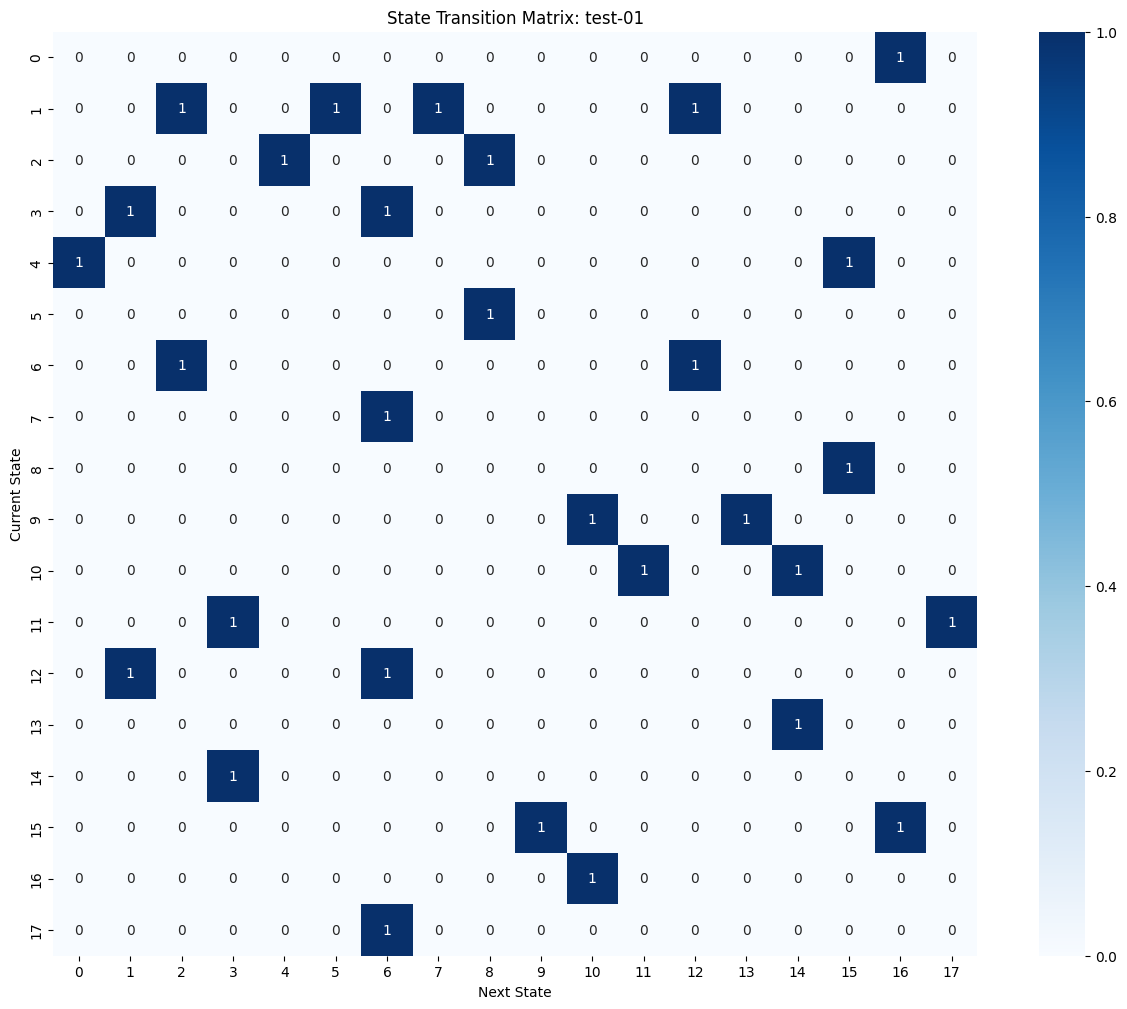


test-02:
  Matrix size: (248, 248)
  Number of transitions: 1440.0
  Sparsity: 0.9766


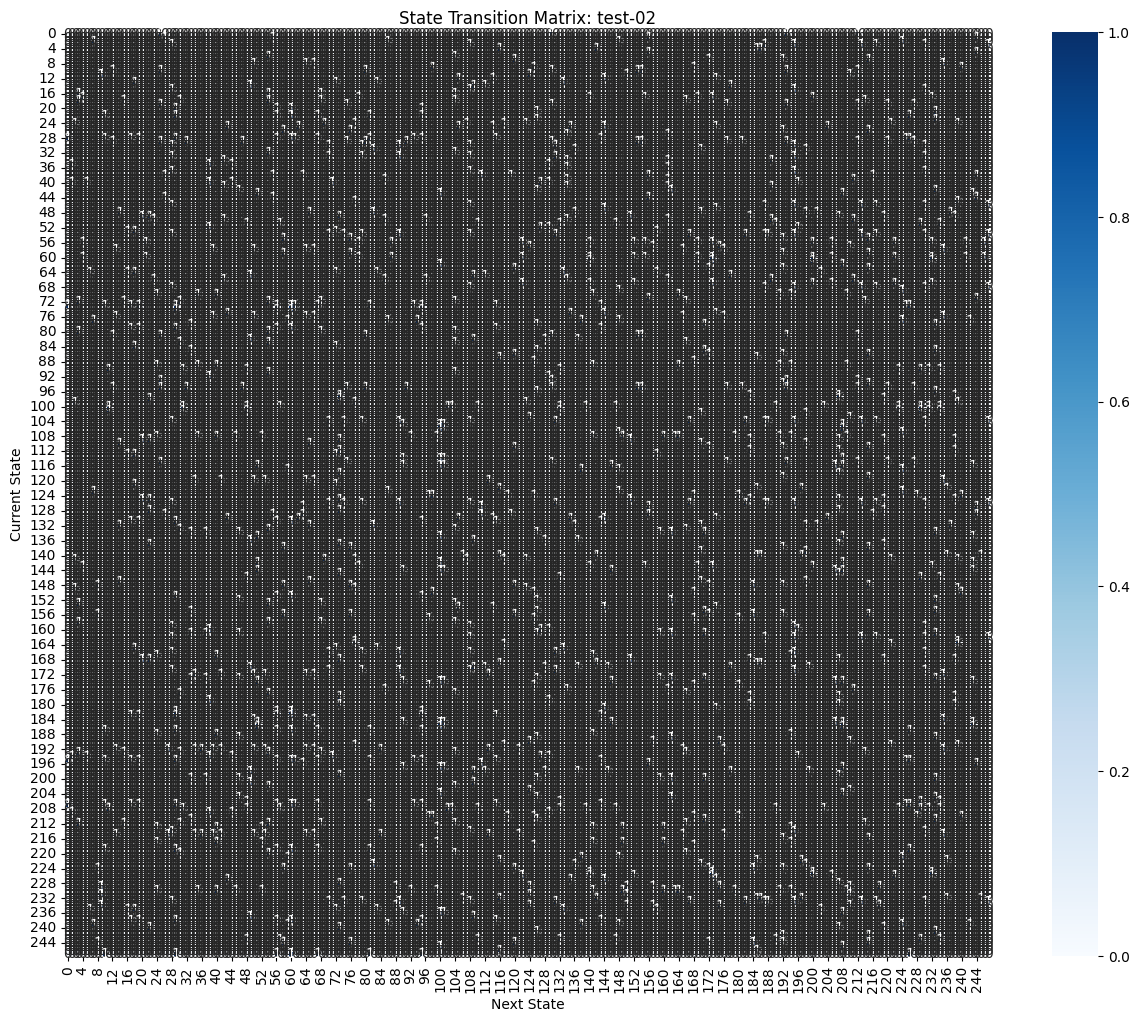

In [4]:
# Analyze state transition matrices
print("State Transition Matrix Analysis:")
print("=" * 50)

for i, result in enumerate(empirical_results):
    config_name = result['config_name']
    transition_matrix = result['transition_matrix']
    
    if transition_matrix is not None:
        print(f"\n{config_name}:")
        print(f"  Matrix size: {transition_matrix.shape}")
        print(f"  Number of transitions: {np.sum(transition_matrix)}")
        print(f"  Sparsity: {1 - np.count_nonzero(transition_matrix) / transition_matrix.size:.4f}")
        
        # # Visualize transition matrix for smaller configurations
        # if transition_matrix.shape[0] <= 20:
        plt.figure(figsize=(16, 12))
        sns.heatmap(transition_matrix, annot=True, cmap='Blues', 
                    fmt='g', square=True)
        plt.title(f'State Transition Matrix: {config_name}')
        plt.xlabel('Next State')
        plt.ylabel('Current State')
        plt.show()
        # else:
        #     print(f"  (Matrix too large to visualize: {transition_matrix.shape})")
    else:
        print(f"\n{config_name}: No periodic behavior detected")
